In [1]:
import numpy as np
from dataclasses import dataclass
from sklearn.datasets import load_diabetes
import pandas as pd

/var/folders/1j/chhd52wn0z97rq9skbstg0_00000gn/T/ipykernel_4520/2344207688.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [184]:
np.max(np.arange(1,10).reshape(3,3))

9

In [211]:
@dataclass
class SplitData:
    """
    A dataclass for representing the result of a data split at a Decision Tree node, including details necessary for propagating splits across the tree.

    Attributes:
        left_partition_mask (np.ndarray): A boolean mask indicating samples allocated to the left child node based on the split.
        right_partition_mask (np.ndarray): A boolean mask indicating samples allocated to the right child node based on the split.
        left_count (int): Number of samples in the left partition, facilitating efficient calculation of statistics or further splits.
        right_count (int): Number of samples in the right partition, facilitating efficient calculation of statistics or further splits.
        feat_index (int): Index of the feature used for splitting, enabling traceability of the decision path within the tree.
        cost (float): The cost or impurity reduction achieved by this split, used to assess the quality of the split.
        thresh (float): Threshold value for the feature at this split, determining the boundary between left and right partitions.
        
    This structure is crucial for the iterative construction and analysis of Decision Trees, where each node's decision to split data affects subsequent nodes' decisions.
    """
    left_partition_mask: np.ndarray
    right_partition_mask: np.ndarray
    left_count: int
    right_count: int 
    feat_index: int 
    cost: float 
    thresh: float

    def __str__(self):
        cost_rounded = float(self.cost)
        cost_rounded = round(cost_rounded, 3)

        thresh_rounded = float(self.thresh)
        thresh_rounded = round(thresh_rounded, 3)

        return ', '.join([
            f'cost={cost_rounded}', 
            f'feature_index={self.feat_index}', 
            f'left_count={self.left_count}',
            f'right_count={self.right_count}', 
            f'thresh={thresh_rounded}',
        ])
    

class TreeNode:

    # def compute_out_per_node(self, X, partition_mask):
    #     output_mask = X[:, self.feat_index] <= self.thresh
    #     output_mask = output_mask.astype(np.int32)
    #     print(f'(d={self.depth_index}, w={self.width_index}) output_mask = {output_mask}')
    #     num_samples = np.sum(output_mask)
    #     self.out_per_node = np.sum(y * output_mask) / num_samples
    #     self.num_samples = num_samples
        # self.out_per_node = np.mean(y * output_mask)
        # output_mask = X[:, self.feat_index]

    def __init__(self, 
                    X : np.array, 
                    y : np.array,
                    max_depth=5, 
                    min_leaves=1,
                    depth_index=0,
                    width_index=0,
                    node_type='init_node',
                    feat_index=0,
                    partition=None,
                    num_samples=None,
                    thresh=None
                 ):
        
        self.depth_index = depth_index
        self.width_index = width_index

        self.max_depth = max_depth 
        self.min_leaves = min_leaves

        if partition is None:
            self.partition = np.ones((y.shape[0],))
            self.num_samples = y.shape[0]
            self.thresh = np.max(X)
            self.feat_index = 0
        else:
            self.partition = partition
            self.num_samples = num_samples
            self.thresh = thresh
            self.feat_index = feat_index
            
        # self.num_samples = np.sum(self.partition)
        self.out_per_node = np.sum(y * self.partition) / self.num_samples

        split_data = self.split_by_min_feat_thresh(X, y, partition)
        
        next_depth = self.depth_index + 1
        is_not_max_depth = self.max_depth > next_depth        
        left_is_not_max_leaves = min_leaves <= split_data.left_count
        right_is_not_max_leaves = min_leaves <= split_data.right_count
        
        grow_left = (is_not_max_depth and left_is_not_max_leaves) or split_data.cost != 0.0
        grow_right = (is_not_max_depth and right_is_not_max_leaves) or split_data.cost != 0.0

        self.feat_index = split_data.feat_index
        self.node_type = node_type
        # self.compute_out_per_node(X, y)

        # print(f'[{self.depth_index}/{self.max_depth}] out_per_node={round(float(self.out_per_node), 3)}, num_samples={self.num_samples}, node_type={node_type}, grow_left={grow_left}, grow_right={grow_right}, {split_data}')
        # print(f'[{self.depth_index}/{self.max_depth}] num_samples={self.num_samples}, partition={self.partition}') 
        # print(f'[{self.depth_index}/{self.max_depth}] left_partition={split_data.left_partition_mask}') 
        # print(f'[{self.depth_index}/{self.max_depth}] right_partition={split_data.right_partition_mask}') 

        self.left_node, self.right_node = None, None
        
        if grow_left:
            self.left_node = TreeNode(
                                X, y, 
                                max_depth=max_depth, 
                                min_leaves=min_leaves,
                                depth_index=next_depth,
                                width_index=self.width_index,
                                node_type='left_node',
                                feat_index=split_data.feat_index,
                                partition=split_data.left_partition_mask,
                                num_samples=split_data.left_count,
                                thresh=split_data.thresh,
                            )

        if grow_right:
            self.right_node = TreeNode(
                                X,y,
                                max_depth=max_depth,
                                min_leaves=min_leaves,
                                depth_index=next_depth,
                                width_index=self.width_index + 1,
                                node_type='right_node',
                                feat_index=split_data.feat_index,
                                partition=split_data.right_partition_mask,
                                num_samples=split_data.right_count,
                                thresh=split_data.thresh
                            )
    
    def split_by_min_thresh(self, X, y, feat_index, partition_mask=None):
        thresh = np.unique(X[:,feat_index]).reshape(1,-1)
        selected_feat = X[:,feat_index].reshape(-1,1)
        is_left_sampler = (selected_feat <= thresh)
        is_right_sampler = ~is_left_sampler

        if partition_mask is not None:
            partition_mask = np.hstack(is_left_sampler.shape[1] * [ partition_mask.reshape(-1,1) ])
            is_left_sampler = is_left_sampler & partition_mask
            is_right_sampler = is_right_sampler & partition_mask

        stacked_targets = np.hstack([y.reshape(-1,1)] * is_left_sampler.shape[1])
        left_sampled, right_sampled = is_left_sampler * stacked_targets, is_right_sampler * stacked_targets

        n_samples_left, n_samples_right = np.sum(is_left_sampler, axis=0), np.sum(is_right_sampler, axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            left_samples_mean = np.where(n_samples_left == 0, 0, np.sum(left_sampled, axis=0) / n_samples_left)
            right_samples_mean = np.where(n_samples_right == 0, 0, np.sum(right_sampled, axis=0) / n_samples_right)
        
        var_left = is_left_sampler * (left_sampled - left_samples_mean.reshape(1,-1)) ** 2
        var_right = is_right_sampler * (right_sampled - right_samples_mean.reshape(1,-1)) ** 2

        with np.errstate(divide='ignore', invalid='ignore'):
            var_left = np.where(n_samples_left == 0, 0, np.sum(var_left, axis=0) / n_samples_left)
            var_right = np.where(n_samples_right == 0, 0, np.sum(var_right, axis=0) / n_samples_right)

        total_samples = left_sampled.shape[0]
        assert total_samples == right_sampled.shape[0], 'wrong total samples'

        ratio_left, ratio_right = n_samples_left / total_samples, n_samples_right / total_samples
        thresh_cost = ratio_left * var_left + ratio_right * var_right
        min_thresh_index = np.argmin(thresh_cost)

        return SplitData(
            left_partition_mask=is_left_sampler[:, min_thresh_index],
            right_partition_mask=is_right_sampler[:, min_thresh_index],
            left_count=np.sum(is_left_sampler[:, min_thresh_index]),
            right_count=np.sum(is_right_sampler[:, min_thresh_index]),
            feat_index=feat_index,
            cost=np.min(thresh_cost),
            thresh=thresh.reshape(-1)[min_thresh_index] 
        )

    def split_by_min_feat_thresh(self, X, y, partition):
        feat_count = X.shape[1]
        min_split_data = self.split_by_min_thresh(X, y, 0)

        for feat_index in range(1, feat_count):
            split_data = self.split_by_min_thresh(X, y, feat_index, partition)
            if min_split_data.cost > split_data.cost:
                min_split_data = split_data

        return min_split_data
    
    def prediction_per_node(self, X, y_preds):
        prediction_mask = X[:,self.feat_index] <= self.thresh
        prediction_mask = prediction_mask * self.partition
        prediction_indices = np.nonzero(prediction_mask)[0]
        
        # print(f'[(d={self.depth_index}, w={self.width_index})], node_type = {self.node_type}, num_samples={self.num_samples}')
        # print(f'[(d={self.depth_index}, w={self.width_index})], prediction_indices = {prediction_indices}\n')
        y_preds[prediction_indices] = self.out_per_node
        
        if self.left_node is not None:
            self.left_node.prediction_per_node(X, y_preds)
        
        if self.right_node is not None:
            self.right_node.prediction_per_node(X, y_preds)




In [212]:

from sklearn.datasets import load_diabetes
import pandas as pd

class DumbDecisionTreeRegressor:
    def __init__(
            self,
            max_depth=5, 
            min_leaves=1, 
        ):

        self.max_depth=max_depth
        self.min_leaves=min_leaves


    def fit(self, X, y):
        self.node = TreeNode(X, y, 
                             max_depth=self.max_depth, 
                             min_leaves=self.min_leaves, 
                             depth_index=0
                            )
        

    def predict(self, X):
        y_preds = np.zeros((X.shape[0],))
        self.node.prediction_per_node(X, y_preds)
        return y_preds
        

In [213]:
data = load_diabetes()
X,y = data['data'], data['target']
max_depth = 10
min_leaves = 1

model = DumbDecisionTreeRegressor(max_depth=max_depth, min_leaves=min_leaves)
model.fit(X,y)

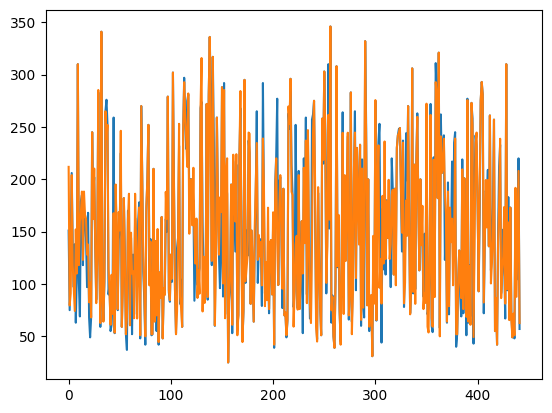

In [214]:
import matplotlib.pyplot as plt

y_preds = model.predict(X)

plt.plot(np.arange(y.shape[0]), y)
plt.plot(np.arange(y.shape[0]), y_preds)
plt.show()

In [197]:
count_eq = 0

for v in zip(y, y_preds):
    print(v)
    count_eq += int(v[0] == v[1])

print('total ratio: ', count_eq / y_preds.shape[0])

(151.0, 211.875)
(75.0, 79.5)
(141.0, 91.0)
(206.0, 206.0)
(135.0, 135.0)
(97.0, 97.0)
(138.0, 74.22222222222223)
(63.0, 152.13348416289594)
(110.0, 110.0)
(310.0, 310.0)
(101.0, 101.0)
(69.0, 159.74468085106383)
(179.0, 179.0)
(185.0, 188.28571428571428)
(118.0, 118.0)
(171.0, 188.28571428571428)
(166.0, 166.0)
(144.0, 162.4)
(97.0, 97.0)
(168.0, 168.0)
(68.0, 68.0)
(49.0, 101.2)
(68.0, 68.0)
(245.0, 245.0)
(184.0, 184.0)
(202.0, 210.25)
(137.0, 137.0)
(85.0, 85.0)
(131.0, 131.0)
(283.0, 285.3333333333333)
(129.0, 129.0)
(59.0, 59.0)
(341.0, 341.0)
(87.0, 87.0)
(65.0, 65.0)
(102.0, 106.0)
(265.0, 265.0)
(276.0, 276.0)
(252.0, 252.0)
(90.0, 114.75)
(100.0, 92.0)
(55.0, 55.0)
(61.0, 108.80459770114942)
(92.0, 92.0)
(259.0, 167.6)
(53.0, 53.5)
(190.0, 190.0)
(142.0, 142.0)
(75.0, 76.0)
(142.0, 168.7)
(155.0, 155.0)
(225.0, 246.33333333333334)
(59.0, 59.0)
(104.0, 104.0)
(182.0, 182.0)
(128.0, 128.0)
(52.0, 52.0)
(37.0, 37.0)
(170.0, 170.0)
(170.0, 186.2)
(61.0, 61.0)
(144.0, 149.0)
(52.0

In [107]:
np.mean(y) / np.mean(y_preds)

1.505171312908521

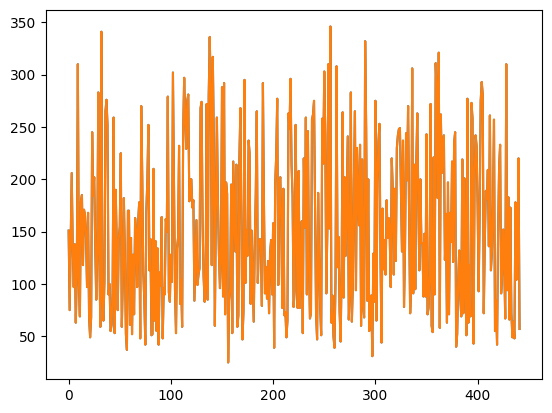

In [19]:
from sklearn.tree import DecisionTreeRegressor

model_sklearn = DecisionTreeRegressor()
model_sklearn.fit(X,y)

y_preds_sklearn = model_sklearn.predict(X)

plt.plot(np.arange(y.shape[0]), y)
plt.plot(np.arange(y.shape[0]), y_preds_sklearn)
plt.show()

### Next Thing TODO
- Figure out a way to debug our implementation.
- If we can plot the decision trees that were made that would be great.

### Identified Bug
- Write indices doesn't shrink - FIXED (But not fully FIXED)
- Probably Tree is ain't deep enough